In [5]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks

<!-- <span style="font-family: arial; font-size:25px; color:pink">

Open ROOT file and extract data -->

In [6]:
hit_data_1101 = rf.get_ROOT_data_zip("TB_FIRE_1101_hits.root")

# hit_data_1096 = rf.get_ROOT_data_zip("TB_FIRE_1096_hits.root")

# hit_data_1056 = rf.get_ROOT_data_zip("TB_FIRE_1056_hits.root")

# hit_data_1057 = rf.get_ROOT_data_zip("TB_FIRE_1057_hits.root")

# hit_data_1079 = rf.get_ROOT_data_zip("TB_FIRE_1079_hits.root")

TB_FIRE_1101_hits.root finished


<!-- <span style="font-family: arial; font-size:25px; color:pink">

Hit Counts and Amp in Single Planes -->

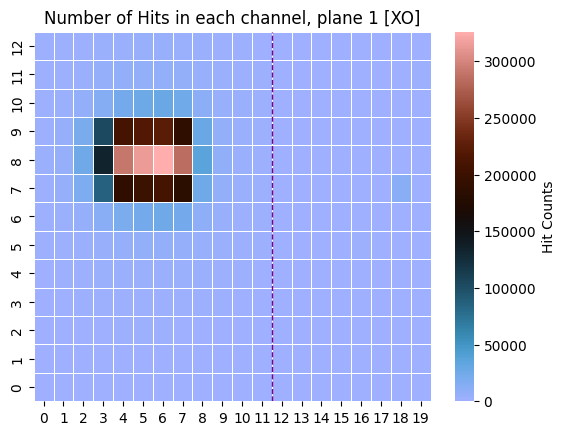

In [3]:
rf.hits_amount_colormap_single_plane(hit_data_1101, 1, cmap="berlin")

In [ ]:
hit_data_1101_with_distances = rf.Radii_from_Initial_position(hit_data_1101)

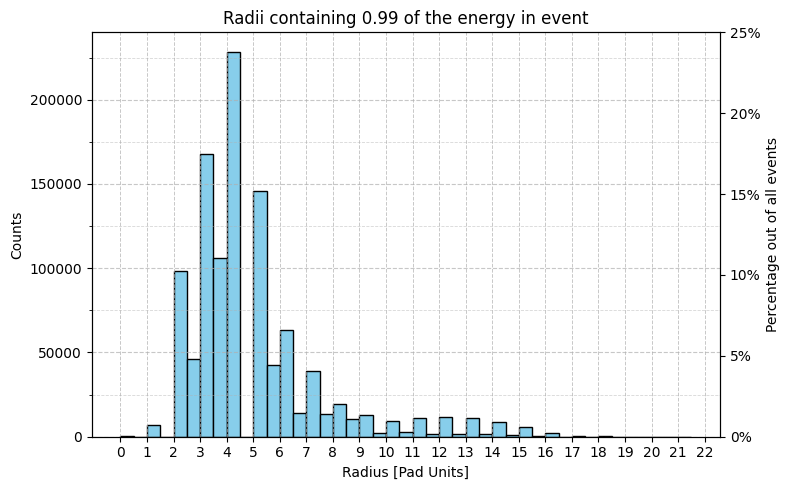

In [9]:
rf.frac_energy_radii_histo(hit_data_1101_with_distances, 0.99)